In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import nltk
from tethne.readers import zotero
import pandas as pd
import matplotlib.pyplot as plt

# I moved our normalization and filtering functions into
#  an external module. If you want to change these functions,
#  you an either redefine them in this notebook or modify
#  them in the file helpers.py.
from helpers import normalize_token, filter_token

# 1.2. Change over time

In computational humanities, we are often interested in whether and how phenomena change over time. In this notebook we will perform a simple time-series analysis of tokens in our corpus. This will get us moving toward analyizing more complex temporal trends.

## Load corpus and metadata

Just as we did in the last notebook, we'll load our texts and metadata.

In [4]:
text_root = '../../data/EmbryoProjectTexts/files'
zotero_export_path = '../../data/EmbryoProjectTexts'

documents = nltk.corpus.PlaintextCorpusReader(text_root, 'https.+')
metadata = zotero.read(zotero_export_path, index_by='link', follow_links=False)

## Has the prevalence of a token increased or decreased over time?

In the last notebook, we looked at the distribution (frequency) of tokens over time. It is one thing to make a pretty figure; it is another to say with some degree of confidence that a token is becoming more or less prevalent over time.

The simplest approach to this problem is a linear regression model:

$Y_i = \beta_0 + \beta X_i + \epsilon_i$

where $Y$ is the response variable (frequency of a token), $X$ is the predictor variable (publication date), $\beta$ is the regression coefficient, and $\epsilon_i$ is the error for observation $i$.

Up to now, we have discussed token frequency in terms of raw token counts. Since the number of texts per year may not be fixed, however, what we really want to model is the probability of a token. We don't have direct access to the probability of a token, but for most practical purposes the Maximum Likelihood Estimator for that probability is just the frequency $f(t) = \frac{N_{token}}{N_{total}}$ of the token.

To get the **Probability Distribution** of a token, we first calculate the frequency distribution:

In [5]:
word_counts = nltk.FreqDist([normalize_token(token) 
                             for token in documents.words() 
                             if filter_token(token)])

$N_{embryo}$

In [6]:
print 'N_e', word_counts['embryo']
print 'N', word_counts.N()

N_e 5302
N 544480


$f("embryo") = \frac{N_{embryo}}{N}$

In [7]:
word_counts.freq('embryo')

0.009737731413458713

...and then we use NLTK's [``MLEProbDist``](http://www.nltk.org/api/nltk.html#nltk.probability.MLEProbDist) (Maximum Likelihood Estimator) to obtain the probability distribution.

In [8]:
word_probs = nltk.MLEProbDist(word_counts)

$p("embryo") ~= \hat{p}("embryo") = f("embryo") $

In [9]:
print word_probs.prob('embryo')    # Probability of an observed token to be 'embryo'.

0.00973773141346


Since we are interested in change over time, we need to generate a conditional probability distribution. 

Here is our conditional frequency distribution (as before):

$N("embryo" \Bigm| year)$

In [10]:
word_counts_over_time = nltk.ConditionalFreqDist([
        (metadata[fileid].date, normalize_token(token))
         for fileid in documents.fileids()
         for token in documents.words(fileids=[fileid])
         if filter_token(token)
    ])

In [26]:
embryo_counts = pd.DataFrame(columns=['Year', 'Count'])
for i, (year, counts) in enumerate(word_counts_over_time.items()):
    embryo_counts.loc[i] = [year, counts['embryo']]

In [27]:
embryo_counts

,Year,Count
0,2016,26
1,2007,434
2,2008,433
3,2009,350
4,2010,1140
5,2011,575
6,2012,366
7,2013,482
8,2014,1242
9,2015,254


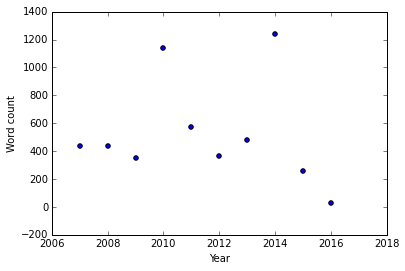

In [28]:
plt.scatter(embryo_counts.Year, embryo_counts.Count)
plt.ylabel('Word count')
plt.xlabel('Year')
plt.show()

$f("embryo" \Bigm| year)$

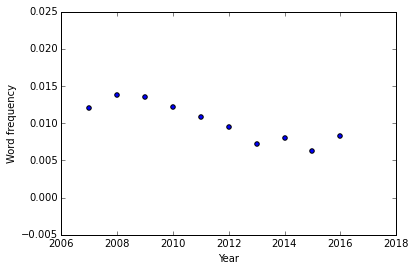

In [30]:
embryo_freq = pd.DataFrame(columns=['Year', 'Frequency'])
for i, (year, counts) in enumerate(word_counts_over_time.items()):
    embryo_freq.loc[i] = [year, counts.freq('embryo')]
    
plt.scatter(embryo_freq.Year, embryo_freq.Frequency)
plt.ylabel('Word frequency')
plt.xlabel('Year')
plt.show()

$\hat{p}("embryo" \Bigm| year)$

In [32]:
word_probs_over_time = nltk.ConditionalProbDist(word_counts_over_time, nltk.MLEProbDist)

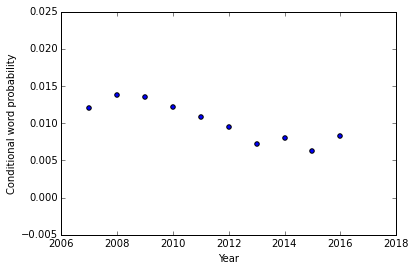

In [33]:
embryo_prob = pd.DataFrame(columns=['Year', 'Probability'])
for i, (year, probs) in enumerate(word_probs_over_time.items()):
    embryo_prob.loc[i] = [year, probs.prob('embryo')]
    
plt.scatter(embryo_prob.Year, embryo_prob.Probability)
plt.ylabel('Conditional word probability')
plt.xlabel('Year')
plt.show()

In [34]:
print 'N(w|c=2016) =', word_counts_over_time[2016]['embryo']
print 'f(w|c=2016) =', word_counts_over_time[2016].freq('embryo')
print '^p(w|c=2016) =', word_probs_over_time[2016].prob('embryo')

N(w|c=2016) = 26
f(w|c=2016) = 0.00832
^p(w|c=2016) = 0.00832


Now we'll take a look at the token that we'd like to analyze. Let's try ``chicken``.

Here we get the probability for each year for the token ``chicken``:

In [40]:
chicken_data = pd.DataFrame(columns=['Year', 'Probability'])
for i, (year, probs) in enumerate(word_probs_over_time.items()):
    chicken_data.loc[i] = [year, probs.prob('chicken')]

In [41]:
chicken_data

,Year,Probability
0,2016,0.000000
1,2007,0.000223
2,2008,0.000286
3,2009,0.000115
4,2010,0.000170
5,2011,0.000094
6,2012,0.000052
7,2013,0.000165
8,2014,0.000071
9,2015,0.000049


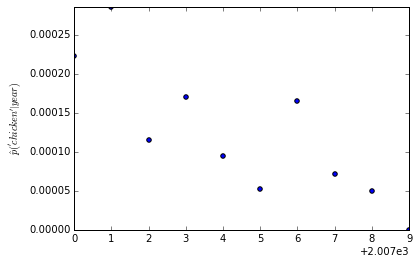

In [42]:
# Create a scatterplot.
plt.scatter(chicken_data.Year, chicken_data.Probability)    

# Scale the Y axis.
plt.ylim(chicken_data.Probability.min(), chicken_data.Probability.max())    

# Scale the X axis.
plt.xlim(chicken_data.Year.min(), chicken_data.Year.max())

plt.ylabel('$\\hat{p}(\'chicken\'|year)$')
plt.show()    # Render the figure.

The SciPy package provides a Ordinary Least Squares linear regression function called [``linregress()``](http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.linregress.html). We can use that to estimate the model parameters from our data.

^Beta: -2.38956045956e-05
^Beta_0: 0.0481885497774
r-squared: 0.676091199243
p: 0.00350319816755


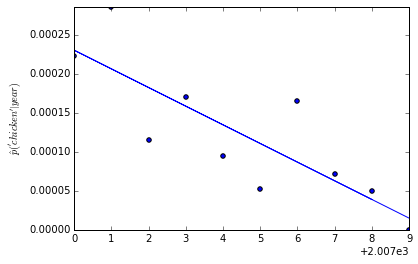

In [44]:
from scipy.stats import linregress
Beta, Beta0, r, p, stde = linregress(chicken_data.Year, chicken_data.Probability)

print '^Beta:', Beta
print '^Beta_0:', Beta0
print 'r-squared:', r*r
print 'p:', p

plt.scatter(chicken_data.Year, chicken_data.Probability)    
plt.plot(chicken_data.Year, Beta0 + Beta*chicken_data.Year)    # Array math!
plt.ylim(chicken_data.Probability.min(), chicken_data.Probability.max())    
plt.xlim(chicken_data.Year.min(), chicken_data.Year.max())

plt.ylabel('$\\hat{p}(\'chicken\'|year)$')
plt.show()    # Render the figure.

At first pass, our linear model looks like a remarkably good fit. Our r-squared value is not too bad, and we have a very low p value. The problem with interpreting that p-value, however, is that data derived from texts rarely satisfy the assumptions of the t-test used to assess significance. Aside from the fact that we have very few "observations", does the distribution of Y values (token probabilities) shown below look normally distributed to you?

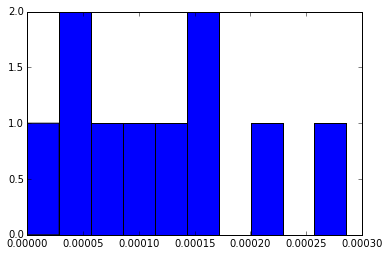

In [45]:
plt.hist(chicken_data.Probability)
plt.show()

We need to use an hypothesis test that does not assume normality, and can handle the small sample size. One such approach is a [**permutation test**](http://avesbiodiv.mncn.csic.es/estadistica/permut2.pdf). 

Our null hypothesis is that:

$H_0: \beta = 0$

That is, that there is no change in the probability of our token (``chicken``, in this case) over time. 

We will shuffle our response variable, $Y$, a whole bunch of times. Each time we shuffle the data (a permutation), we will re-calculate the regression parameter $\beta_{\pi}$. We can reject $H_0$ with a confidence of $p = 0.05$ iff our observed $\hat{\beta}$ falls outside the inner 95% of the resampled distribution.

In [65]:
import numpy as np

In [47]:
# We can use underscores `_` for values that we don't want to keep.
samples = pd.DataFrame(columns=['Beta_pi', 'Beta0_pi'])
for i in xrange(1000):
    shuffled_probability = np.random.permutation(chicken_data.Probability)
    # linregress() returns five parameters; we only care about the first two.
    Beta_pi, Beta0_pi, _, _, _ = linregress(chicken_data.Year, shuffled_probability)
    samples.loc[i] = [Beta_pi, Beta0_pi]

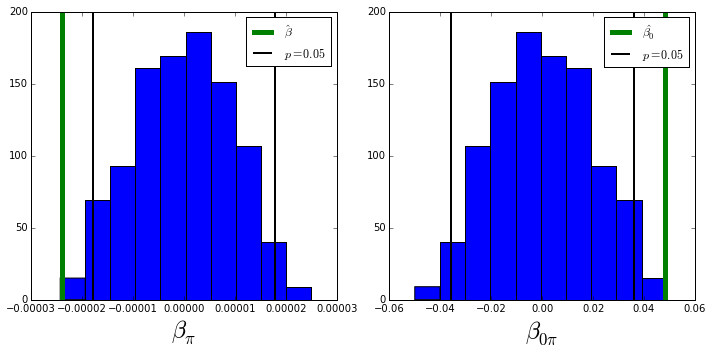

In [48]:
plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.hist(samples.Beta_pi)    # Histogram of Beta values from permutations.
plt.plot([Beta, Beta], [0, 200],     # Beta from the observed data.
         lw=5, label='$\\hat{\\beta}$')

# Plot the upper and lower bounds of the inner 95% probability.
Beta_upper = np.percentile(samples.Beta_pi, 97.5)
Beta_lower = np.percentile(samples.Beta_pi, 2.5)
plt.plot([Beta_upper, Beta_upper], [0, 200], color='k', lw=2, label='$p = 0.05$')
plt.plot([Beta_lower, Beta_lower], [0, 200], color='k', lw=2)

plt.legend()
plt.xlabel('$\\beta_{\\pi}$', fontsize=24)

# Same procedure for Beta0.
plt.subplot(122)
plt.hist(samples.Beta0_pi)
plt.plot([Beta0, Beta0], [0, 200], lw=5, label='$\\hat{\\beta_0}$')

Beta0_upper = np.percentile(samples.Beta0_pi, 97.5)
Beta0_lower = np.percentile(samples.Beta0_pi, 2.5)
plt.plot([Beta0_upper, Beta0_upper], [0, 200], color='k', lw=2, label='$p = 0.05$')
plt.plot([Beta0_lower, Beta0_lower], [0, 200], color='k', lw=2)

plt.legend()
plt.xlabel('$\\beta_{0\\pi}$', fontsize=24)
plt.tight_layout()
plt.show()

As we can see from the plots above, our $\hat{\beta}$ calculated from the observed data falls outside the inner 95% of the samples, and so we can reject $H_0$: the term ``chicken`` is decreasing in prevalance over time.